<a href="https://colab.research.google.com/github/funway/nid-imbalance-study/blob/main/classification/f_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP (Multilayer Perceptron) 多层感知机

## Colab Env

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Modules import & Globals setup

In [ ]:
### Modules ###
import os
import numpy as np

from pathlib import Path
from datetime import datetime
from collections import Counter


### Globals ###

## 数据目录
dataset = 'CSE-CIC-IDS2018'
datasets_folder = Path('/content/drive/MyDrive/NYIT/870/datasets')
preprocessed_folder = datasets_folder / 'preprocessed' / dataset
balanced_folder = datasets_folder / 'balanced' / dataset
results_folder = Path('/content/drive/MyDrive/NYIT/870/model_result') / dataset

In [ ]:
# scaling 支持: standard, minmax, robust, l1pstandard, l1pminmax
scaling_method = 'standard'
# scaling_method = 'minmax'

resample_scheme = 1

oversampleing_method = 'ROS1+cGAN'
undersampling_method = 'RUS'
classifier = 'MLP'

if resample_scheme == 0:
    model_best_file = results_folder / f'{dataset}_{scaling_method}_s{resample_scheme}_{classifier}-best.keras'
    model_final_file = results_folder / f'{dataset}_{scaling_method}_s{resample_scheme}_{classifier}-final.keras'
else:
    model_best_file = results_folder / f'{dataset}_{scaling_method}_s{resample_scheme}_{oversampleing_method}_{undersampling_method}_{classifier}-best.keras'
    model_final_file = results_folder / f'{dataset}_{scaling_method}_s{resample_scheme}_{oversampleing_method}_{undersampling_method}_{classifier}-final.keras'

In [ ]:
if resample_scheme == 0:
    file_X_train = preprocessed_folder / 'integrated' / f'train_X_{scaling_method}.npy'
    file_y_train = preprocessed_folder / 'integrated' / f'train_label_{scaling_method}.npy'
else:
    file_X_train = balanced_folder / f'train_X_{scaling_method}_s{resample_scheme}_{oversampleing_method}_{undersampling_method}.npy'
    file_y_train = balanced_folder / f'train_label_{scaling_method}_s{resample_scheme}_{oversampleing_method}_{undersampling_method}.npy'

file_X_valid = preprocessed_folder / 'integrated' / f'valid_X_{scaling_method}.npy'
file_y_valid = preprocessed_folder / 'integrated' / f'valid_label_{scaling_method}.npy'

file_X_test = preprocessed_folder / 'integrated' / f'test_X_{scaling_method}.npy'
file_y_test = preprocessed_folder / 'integrated' / f'test_label_{scaling_method}.npy'

print(f"[{datetime.now().strftime('%x %X')}] loading datasets...")
X_train = np.load(file_X_train)
y_train = np.load(file_y_train)
X_valid = np.load(file_X_valid)
y_valid = np.load(file_y_valid)
X_test = np.load(file_X_test)
y_test = np.load(file_y_test)

report_dataset = ''
report_dataset += f'\nTrain set: {file_X_train.name}, {file_y_train.name} \n'
report_dataset += f'    shape: {X_train.shape}, {y_train.shape} \n'
report_dataset += f"    labels: { {int(k): v for k, v in sorted(Counter(y_train).items())} } \n"
report_dataset += f'\n Valid set: {file_X_valid.name}, {file_y_valid.name} \n'
report_dataset += f'    shape: {X_valid.shape}, {y_valid.shape} \n'
report_dataset += f"    labels: { {int(k): v for k, v in sorted(Counter(y_valid).items())} } \n"
report_dataset += f'\n Test set: {file_X_test.name}, {file_y_test.name} \n'
report_dataset += f'    shape: {X_test.shape}, {y_test.shape} \n'
report_dataset += f"    labels: { {int(k): v for k, v in sorted(Counter(y_test).items())} } \n"

print(report_dataset)

[04/27/25 01:44:24] loading datasets...

Train set: train_X_standard_s1_ROS1+cGAN_RUS.npy, train_label_standard_s1_ROS1+cGAN_RUS.npy 
    shape: (3175177, 70), (3175177,) 
    labels: {0: 1600000, 1: 200000, 2: 20000, 3: 20000, 4: 200000, 5: 20000, 6: 200000, 7: 100000, 8: 200000, 9: 111912, 10: 50000, 11: 154683, 12: 128511, 13: 20000, 14: 150071} 

 Valid set: valid_X_standard.npy, valid_label_standard.npy 
    shape: (474693, 70), (474693,) 
    labels: {0: 200000, 1: 28619, 2: 61, 3: 23, 4: 68601, 5: 173, 6: 57619, 7: 4151, 8: 46191, 9: 13989, 10: 1099, 11: 19335, 12: 16064, 13: 9, 14: 18759} 

 Test set: test_X_standard.npy, test_label_standard.npy 
    shape: (474694, 70), (474694,) 
    labels: {0: 200000, 1: 28619, 2: 61, 3: 23, 4: 68602, 5: 173, 6: 57619, 7: 4151, 8: 46191, 9: 13989, 10: 1099, 11: 19336, 12: 16064, 13: 8, 14: 18759} 



In [ ]:
## 给标签向量进行独热编码
from tensorflow.keras.utils import to_categorical

if len(y_train.shape) == 1 or (y_train.ndim == 2 and y_train.shape[1] == 1):
    # 对标签数据进行独热编码 one-hot
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    y_test = to_categorical(y_test)

print(f"[{datetime.now().strftime('%x %X')}] After one-hot: ", y_train.shape, y_valid.shape, y_test.shape)

[04/27/25 01:44:47] After one-hot:  (3175177, 15) (474693, 15) (474694, 15)


## Train Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


np.random.seed(42)
tf.random.set_seed(42)

def train_model(x_train, y_train, x_val, y_val, batch_size=256, epochs=100):
    """模型训练函数

    Args:
        x_train (_type_): 训练集特征矩阵
        y_train (_type_): 训练集标签
        x_val (_type_): 验证集特征矩阵
        y_val (_type_): 验证集标签
        batch_size (int, optional): _description_. Defaults to 256.
        epochs (int, optional): _description_. Defaults to 100.
    """
    print(f"[{datetime.now().strftime('%x %X')}] 🧠 开始训练 MLP 模型...")

    # 1. 定义 MLP 模型结构
    num_features = x_train.shape[1:]
    num_classes = y_train.shape[1]
    # layer_units = [512, 256, 128, 64]
    layer_units = [256, 128, 64, 32]
    layer_dropouts = [0.3, 0.3, 0.2, 0.1]

    model = tf.keras.Sequential([
        layers.Input(shape=num_features),           # 输入层，输入维度等于特征数量

        layers.Dense(layer_units[0], activation='relu'),  # 第一层：全连接 + ReLU
        layers.Dropout(layer_dropouts[0]),                # Dropout 防止过拟合
        layers.BatchNormalization(),                      # Batch 归一化，提高训练稳定性

        layers.Dense(layer_units[1], activation='relu'),  # 第二层：全连接 + ReLU
        layers.Dropout(layer_dropouts[1]),
        layers.BatchNormalization(),

        layers.Dense(layer_units[2], activation='relu'),  # 第三层：全连接 + ReLU
        layers.Dropout(layer_dropouts[2]),
        layers.BatchNormalization(),

        layers.Dense(layer_units[3], activation='relu'),  # 第四层：全连接 + ReLU
        layers.Dropout(layer_dropouts[3]),
        # layers.BatchNormalization(),                    # 最后一个 dense 层建议不加归一化

        layers.Dense(num_classes, activation='softmax')  # 输出层：多分类输出，使用 softmax
    ])

    # 2. 打印模型信息
    print(f"[{datetime.now().strftime('%x %X')}] model summary:")
    model.summary()

    # 3. 定义 Nadam 优化器（Adam + Nesterov 动量
    learning_rate = 0.001
    optimizer = Nadam(learning_rate=learning_rate)

    # 4. 编译模型
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    # 5. 定义 callbacks 方法 (每个 epoch 训练结束后调用)
    callbacks = [
        # ⏹️ 提前停止训练：如果验证集 loss 连续 15 轮没有下降，就停止训练，防止过拟合
        EarlyStopping(
            monitor='val_loss',          # 监控指标是验证集的 loss
            patience=15,                 # 容忍 15 个 epoch 不进步
            restore_best_weights=True    # 自动回滚到验证集 loss 最优的模型参数
        ),

        # 🔽 自动调整学习率：如果验证集 loss 停滞 10 个 epoch，就将学习率乘以 0.1
        ReduceLROnPlateau(
            monitor='val_loss',         # 监控验证集 loss
            factor=0.1,                 # 学习率降低为原来的 1/10
            patience=10                 # 容忍多少个 epoch 无进步
        ),

        # 💾 模型保存器：在验证集 accuracy 最佳时保存整个模型到文件
        ModelCheckpoint(
            filepath=model_best_file,  # 模型保存路径
            monitor='val_accuracy',     # 保存依据是验证集准确率
            save_best_only=True         # 只在 val_accuracy 最佳时才保存
        )
    ]

    # 6. 训练模型
    time_start = datetime.now()
    history = model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        validation_data=(x_val, y_val),
                        verbose=1,
                        callbacks=callbacks)
    time_end = datetime.now()

    print(f"[{time_end.strftime('%x %X')}] 🕗 Train time: {time_end - time_start}")

    return model, history

In [ ]:
forece_train = False  # 是否强制重新训练
model_file = model_final_file

if model_file.exists() and not forece_train:
    print(f"[{datetime.now().strftime('%x %X')}] ❎ 模型已存在，不重新训练")
else:
    # 训练模型
    print(f"[{datetime.now().strftime('%x %X')}] 🤖 build and train model...")
    model, history = train_model(X_train, y_train, X_valid, y_valid)

    # 打印history
    print(f"[{datetime.now().strftime('%x %X')}] history: \n{history.history}")

    # 保存模型
    model.save(model_file)
    print(f"[{datetime.now().strftime('%x %X')}] model saved to {model_file}")

[04/27/25 01:44:47] ❎ 模型已存在，不重新训练


## Evaluate Model

In [ ]:
from tensorflow.keras import models

# 加载模型
# model_file = model_best_file
model_file = model_final_file

model = models.load_model(model_file)
print(f"[{datetime.now().strftime('%x %X')}] 🤖 model loaded from {model_file}")

# 打印模型信息
print(f"[{datetime.now().strftime('%x %X')}] 🧠 model summary:")
model.summary()

[04/27/25 01:44:51] 🤖 model loaded from /content/drive/MyDrive/NYIT/870/model_result/CSE-CIC-IDS2018/CSE-CIC-IDS2018_standard_s1_ROS1+cGAN_RUS_MLP-final.keras
[04/27/25 01:44:51] 🧠 model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,296 (739.44 KB)

 Trainable params: 62,799 (245.31 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 125,601 (490.63 KB)

In [ ]:
print("================= [1] model.evaluate() =================")
# 使用内建的 evaluate 方法快速查看 loss 和 accuracy
results = model.evaluate(X_test, y_test, verbose=1, return_dict=True)
print(f"[{datetime.now().strftime('%x %X')}] 🔹 Loss: {results['loss']:.4f}")
print(f"[{datetime.now().strftime('%x %X')}] 🔹 Accuracy: {results['accuracy']:.4f}")

================= [1] model.evaluate() =================
14835/14835 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.9719 - loss: 0.0497
[04/27/25 01:45:28] 🔹 Loss: 0.0505
[04/27/25 01:45:28] 🔹 Accuracy: 0.9715


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

print("================= [2] Confusion Matrix =================")
# 获取预测结果（概率），再转为类别索引
y_pred_probs = model.predict(X_test, verbose=1)  # 得到的一个矩阵，每行代表一个样本属于每个类别的概率. 比如[0.1, 0.7, 0.2]就表示该样本有0.1的概率属于类别0, 0.7的概率属于类别1
y_pred = np.argmax(y_pred_probs, axis=1)  # 对每行提取值最大的列(提取出每个样本的预测类别)
y_true = np.argmax(y_test, axis=1)  # 提取出每个样本的真实类别

# 保存 y_pred 与 y_true 为 txt 文件
np.savetxt(model_file.parent / 'y_results' / f'{model_file.stem}_y_pred.txt', y_pred, fmt='%d')
np.savetxt(model_file.parent / 'y_results' / f'{model_file.stem}_y_true.txt', y_true, fmt='%d')

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)
print(f"[{datetime.now().strftime('%x %X')}] confusion matrix: \n{cm}")

================= [2] Confusion Matrix =================
14835/14835 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
[04/27/25 01:46:12] confusion matrix: 
[[199443      2      1      9      0      0     16      0      2      0
       0      0    525      1      1]
 [     5  28614      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     8      0     29     12      0      0      0      0      0      0
       0      0      0     12      0]
 [     0      0      0     22      0      0      0      0      0      0
       0      0      0      1      0]
 [     0      0      0      0  68602      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0      0      0    173      0      0      0      0
       0      0      0      0      0]
 [    28      0      0      0      0      0  57591      0      0      0
       0      0      0      0      0]
 [     1      0      0      0      0      0      0   4149      0      0
       1      0 

[04/27/25 01:46:12] labels: ['(Benign) 0', '(Bot) 1', '(Brute Force -Web) 2', '(Brute Force -XSS) 3', '(DDOS attack-HOIC) 4', '(DDOS attack-LOIC-UDP) 5', '(DDoS attacks-LOIC-HTTP) 6', '(DoS attacks-GoldenEye) 7', '(DoS attacks-Hulk) 8', '(DoS attacks-SlowHTTPTest) 9', '(DoS attacks-Slowloris) 10', '(FTP-BruteForce) 11', '(Infilteration) 12', '(SQL Injection) 13', '(SSH-Bruteforce) 14']


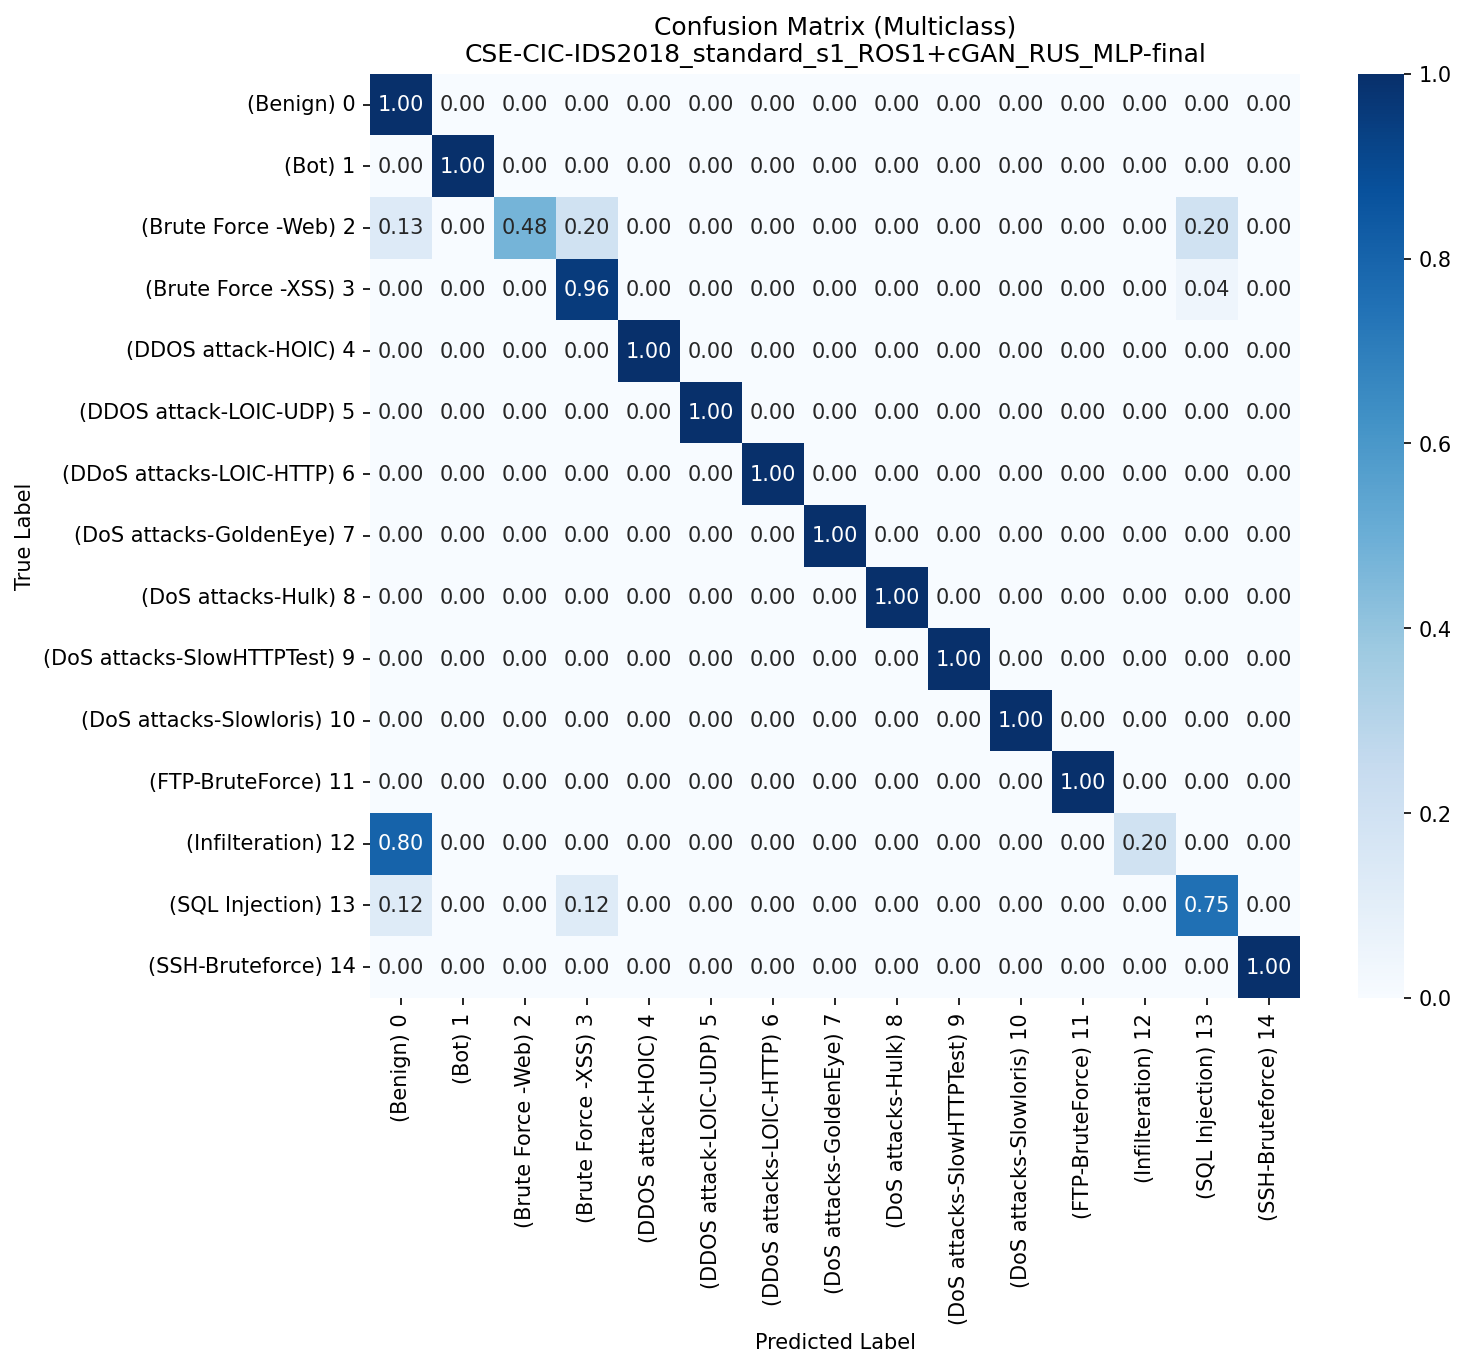

In [ ]:
## 绘制混淆矩阵图形 ##

np.set_printoptions(precision=2, suppress=True)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print(f"[{datetime.now().strftime('%x %X')}] normalized confusion matrix: \n{cm_normalized}")

## Label 特征的数值化编码
label_mapping = {
    "Benign": 0,
    "Bot": 1,
    "Brute Force -Web": 2,
    "Brute Force -XSS": 3,
    "DDOS attack-HOIC": 4,
    "DDOS attack-LOIC-UDP": 5,
    "DDoS attacks-LOIC-HTTP": 6,
    "DoS attacks-GoldenEye": 7,
    "DoS attacks-Hulk": 8,
    "DoS attacks-SlowHTTPTest": 9,
    "DoS attacks-Slowloris": 10,
    "FTP-BruteForce": 11,
    "Infilteration": 12,
    "SQL Injection": 13,
    "SSH-Bruteforce": 14
}
labels = [f"({k}) {v}" for k, v in sorted(label_mapping.items(), key=lambda x: x[1])]
print(f"[{datetime.now().strftime('%x %X')}] labels: {labels}")

# 绘制混淆矩阵
plt.figure(figsize=(10, 8), dpi=150)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title(f"Confusion Matrix (Multiclass)\n{model_file.stem}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# 保存图片
plt.savefig(model_file.with_name(model_file.stem + '_confusion_matrix.png'), bbox_inches='tight')
# 显示图片
plt.show()

In [ ]:
## 输出混淆矩阵文本 ##
report_text_cm = (
    f"[{datetime.now().strftime('%x %X')}] ================= Confusion Matrix =================\n"
)

col_width = 7  # 保证宽度对齐

report_text_cm += " " * 24 + "".join([name[name.index(")")+2:].ljust(col_width) for name in labels]) + "\n"
for i, row in enumerate(cm_normalized):
    row_name = labels[i][:20].ljust(24)
    row_vals = "".join([
        ("-----".ljust(col_width) if val < 1e-4 else f"{val:.3f}".ljust(col_width))
        for val in row])
    report_text_cm += row_name + row_vals + "\n"

print(report_text_cm)

[04/27/25 01:46:13] ================= Confusion Matrix =================
                        0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     
(Benign) 0              0.997  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  0.003  -----  -----  
(Bot) 1                 0.000  1.000  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  
(Brute Force -Web) 2    0.131  -----  0.475  0.197  -----  -----  -----  -----  -----  -----  -----  -----  -----  0.197  -----  
(Brute Force -XSS) 3    -----  -----  -----  0.957  -----  -----  -----  -----  -----  -----  -----  -----  -----  0.043  -----  
(DDOS attack-HOIC) 4    -----  -----  -----  -----  1.000  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  
(DDOS attack-LOIC-UD    -----  -----  -----  -----  -----  1.000  -----  -----  -----  -----  -----  -----  -----  -----  -----  
(DDoS attacks-LOI

In [ ]:
## 多分类报告 ##

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

report_multiclass = classification_report(y_true, y_pred, target_names=labels, zero_division=0, digits=6)
# zero_division 是防止除零告警, 如果有某个类别完全没有判断正确的样本，就会出现除零告警

# Macro 平均 (不考虑不同类别的样本数量差异)
acc_macro = precision_score(y_true, y_pred, average='macro')
rec_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

# Weighted 平均 (考虑不同类别的样本数量差异)
acc_weighted = precision_score(y_true, y_pred, average='weighted')
rec_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

acc = accuracy_score(y_true, y_pred)

report_text_multiclass =  (
    f"[{datetime.now().strftime('%x %X')}] ================= Multiclass Report =================\n"
    + report_multiclass + "\n"
    + f"📊 Macro average\n"
    + f"    Precision: {acc_macro:.6f}\n"
    + f"    Recall:    {rec_macro:.6f}\n"
    + f"    F1 Score:  {f1_macro:.6f}\n\n"
    + f"📊 Weighted average\n"
    + f"    Precision: {acc_weighted:.6f}\n"
    + f"    Recall:    {rec_weighted:.6f}\n"
    + f"    F1 Score:  {f1_weighted:.6f}\n\n"
    + f"🎯 Accuracy: {acc:.6f}\n\n"
)
print(report_text_multiclass)

[04/27/25 01:46:14] ================= Multiclass Report =================
                              precision    recall  f1-score   support

                  (Benign) 0   0.938975  0.997215  0.967219    200000
                     (Bot) 1   0.999930  0.999825  0.999878     28619
        (Brute Force -Web) 2   0.966667  0.475410  0.637363        61
        (Brute Force -XSS) 3   0.500000  0.956522  0.656716        23
        (DDOS attack-HOIC) 4   1.000000  1.000000  1.000000     68602
    (DDOS attack-LOIC-UDP) 5   1.000000  1.000000  1.000000       173
  (DDoS attacks-LOIC-HTTP) 6   0.999722  0.999514  0.999618     57619
   (DoS attacks-GoldenEye) 7   1.000000  0.999518  0.999759      4151
        (DoS attacks-Hulk) 8   0.999957  1.000000  0.999978     46191
(DoS attacks-SlowHTTPTest) 9   1.000000  1.000000  1.000000     13989
  (DoS attacks-Slowloris) 10   0.999090  0.999090  0.999090      1099
         (FTP-BruteForce) 11   0.999741  1.000000  0.999871     19336
          (Infi

In [ ]:
## 二分类报告 ##

# 将多分类标签映射为二分类：
normal_class_label = 0
y_true_bin = np.where(y_true == normal_class_label, 0, 1)  # (判断条件, 条件为True时的值, 条件为False时的值)
y_pred_bin = np.where(y_pred == normal_class_label, 0, 1)

report_binary = classification_report(y_true_bin, y_pred_bin, zero_division=0, digits=6)

# 计算常用二分类指标
acc_bin = accuracy_score(y_true_bin, y_pred_bin)
f1_bin = f1_score(y_true_bin, y_pred_bin)
pre_bin = precision_score(y_true_bin, y_pred_bin)
rec_bin = recall_score(y_true_bin, y_pred_bin)

# 🧮 计算 FPR（误报率） = FP / (FP + TN)
cm_bin = confusion_matrix(y_true_bin, y_pred_bin)
if cm_bin.shape == (2, 2):
    tn, fp, fn, tp = cm_bin.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
else:
    print(f"[{datetime.now().strftime('%x %X')}] ⚠️ confusion matrix shape is not (2, 2)")
    raise Exception("confusion matrix shape is not (2, 2)")

report_text_binary = (
    f"[{datetime.now().strftime('%x %X')}] ================= Binary Report (Normal vs Attack) =================\n"
    + report_binary + "\n"
    + f"🎯 Accuracy       : {acc_bin:.6f}\n"
    + f"✅ Precision      : {pre_bin:.6f}\n"
    + f"🔁 Recall / DR    : {rec_bin:.6f}\n"
    + f"🎯 F1 Score       : {f1_bin:.6f}\n"
    + f"🚨 FPR (误报率)    : {fpr:.6f}\n"
)

print(report_text_binary)

[04/27/25 01:46:14] ================= Binary Report (Normal vs Attack) =================
              precision    recall  f1-score   support

           0   0.938975  0.997215  0.967219    200000
           1   0.997876  0.952813  0.974824    274694

    accuracy                       0.971521    474694
   macro avg   0.968426  0.975014  0.971022    474694
weighted avg   0.973060  0.971521  0.971620    474694

🎯 Accuracy       : 0.971521
✅ Precision      : 0.997876
🔁 Recall / DR    : 0.952813
🎯 F1 Score       : 0.974824
🚨 FPR (误报率)    : 0.002785



In [ ]:
## 保存报告
report_file = model_file.with_name(model_file.stem + '_report.txt')

report_text = report_dataset + '\n' + report_text_cm + '\n' + report_text_multiclass + '\n' + report_text_binary

with open(report_file, 'w') as f:
    f.write(report_text)
    print(f"[{datetime.now().strftime('%x %X')}] report saved to {report_file}")

[04/27/25 01:46:14] report saved to /content/drive/MyDrive/NYIT/870/model_result/CSE-CIC-IDS2018/CSE-CIC-IDS2018_standard_s1_ROS1+cGAN_RUS_MLP-final_report.txt
